## Overview

This notebook demonstrates how to implement and visualize a linear regression model with two input features using PyTorch. The workflow includes:

- Generating synthetic 2D data for regression.
- Building a custom linear regression model using `nn.Module`.
- Training the model with mini-batch gradient descent.
- Visualizing the regression plane before and after training.
- Comparing the effect of different batch sizes on training and validation loss.

## Interpretation

- **Data Generation:**  
  The dataset consists of 20 samples, each with two features. The target values are generated using a linear function with added Gaussian noise.

- **Model Training:**  
  Two models are trained:
  1. The first model uses a batch size of 2.
  2. The second model (`model1`) uses a batch size of 10.

  Both models use stochastic gradient descent (SGD) with a learning rate of 0.1 and are trained for 100 epochs.

- **Visualization:**  
  The notebook visualizes the regression plane both before and after training for `model1`.  
  - Before training, the plane is determined by the model's initial random weights and bias.
  - After training, the plane closely fits the data points, showing the model has learned the underlying linear relationship.

- **Loss Curves:**  
  The loss curves for both models are plotted, showing how the training loss decreases over iterations.

- **Validation:**  
  After training, both models are evaluated on a new validation dataset. The validation loss is reported for each model, allowing comparison of generalization performance.

## Summary of Results

- The regression plane after training fits the data well, confirming that the model has learned the correct relationship between inputs and outputs.
- Both batch sizes (2 and 10) lead to successful training, but the loss curves and final validation losses may differ slightly due to the effect of batch size on optimization dynamics.
- Visualizations clearly show the improvement in the model's predictions after training.
- The notebook provides a clear, step-by-step example of linear regression with multiple inputs, including model evaluation and visualization.

---
**Key Takeaway:**  
This notebook is a practical guide for understanding and visualizing linear regression with multiple inputs in PyTorch, highlighting the impact of batch size and the importance of visualizing model learning.

In [1]:
from torch import nn,optim
import torch
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

torch.manual_seed(1)

# Function to Visualize  the Regression

In [2]:
# The function for plotting a 2D plane for a linear regression model with two inputs

def Plot_2D_Plane(model, dataset, n=0):
    # Extract weights and bias from the model's state_dict
    w1 = model.state_dict()['linear.weight'].numpy()[0][0]  # Weight for x1
    w2 = model.state_dict()['linear.weight'].numpy()[0][1]  # Weight for x2
    b = model.state_dict()['linear.bias'].numpy()           # Bias term

    # Get input features and target values from the dataset
    x1 = dataset.x[:, 0].view(-1, 1).numpy()  # First feature (x1)
    x2 = dataset.x[:, 1].view(-1, 1).numpy()  # Second feature (x2)
    y = dataset.y.numpy()                     # Target values

    # Create a meshgrid for plotting the regression plane
    X, Y = np.meshgrid(
        np.arange(x1.min(), x1.max(), 0.05),  # Range for x1
        np.arange(x2.min(), x2.max(), 0.05)   # Range for x2
    )
    yhat = w1 * X + w2 * Y + b  # Predicted values on the grid

    # Set up the 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the actual data points as red dots
    ax.plot(x1[:, 0], x2[:, 0], y[:, 0], 'ro', label='y')

    # Plot the regression plane
    ax.plot_surface(X, Y, yhat)

    # Label axes
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('y')
    plt.title('estimated plane iteration:' + str(n))
    ax.legend()

    # Show the plot
    plt.show()

# Generating some Data

In [3]:
# Create a 2D dataset for linear regression with two input features

class Data2D(Dataset):
    # Constructor: generate data
    def __init__(self):
        self.x = torch.zeros(20, 2)  # Initialize input tensor of shape (20, 2)
        self.x[:, 0] = torch.arange(-1, 1, 0.1)  # First feature: values from -1 to 0.9
        self.x[:, 1] = torch.arange(-1, 1, 0.1)  # Second feature: same as first
        self.w = torch.tensor([[1.0], [1.0]])    # True weights for both features
        self.b = 1                               # True bias
        self.f = torch.mm(self.x, self.w) + self.b  # Linear function: f = x1*w1 + x2*w2 + b
        self.y = self.f + 0.1 * torch.randn((self.x.shape[0], 1))  # Add Gaussian noise to targets
        self.len = self.x.shape[0]               # Number of samples

    # Get a single sample (input, target)
    def __getitem__(self, index):          
        return self.x[index], self.y[index]
    
    # Return the total number of samples
    def __len__(self):
        return self.len

# Create the dataset object
data_set = Data2D()

# Creating the Model, Optimizer, and Total Loss Function (Cost)

In [4]:
# Create a customized linear regression model using nn.Module

class linear_regression(nn.Module):
    # Constructor: define the linear layer
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)  # Linear layer (input_size -> output_size)
        
    # Forward pass: compute predictions
    def forward(self, x):
        yhat = self.linear(x)  # Pass input through linear layer
        return yhat

# Create the linear regression model (2 inputs, 1 output) and print the parameters
model = linear_regression(2, 1)
print("The parameters: ", list(model.parameters()))

# Create the optimizer (Stochastic Gradient Descent with learning rate 0.1)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Create the cost function (Mean Squared Error)
criterion = nn.MSELoss()

# Create the data loader for batching (batch size 2)
train_loader = DataLoader(dataset=data_set, batch_size=2)

The parameters:  [Parameter containing:
tensor([[ 0.6209, -0.1178]], requires_grad=True), Parameter containing:
tensor([0.3026], requires_grad=True)]


# Training the Model with Mini-Batch Gradient Descent

Before Training: 


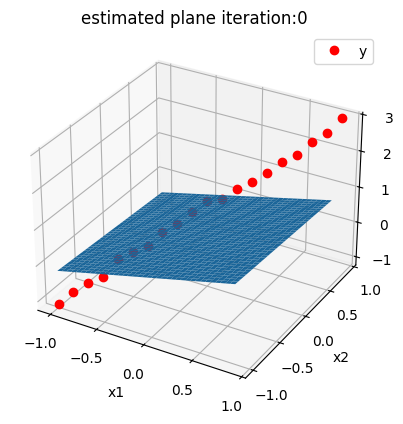

After Training: 


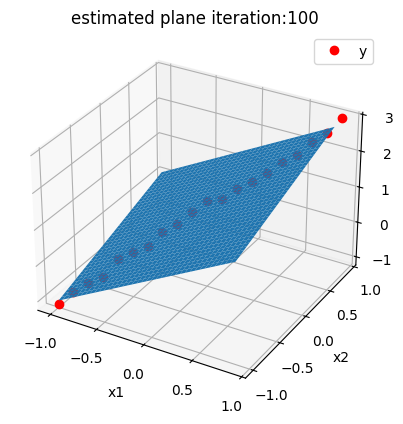

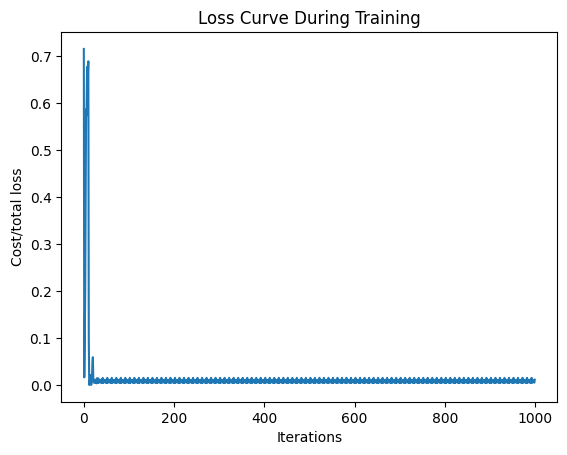

In [5]:
# Train the model

LOSS = []  # List to store loss values for each iteration

print("Before Training: ")
Plot_2D_Plane(model, data_set)   # Visualize the initial (untrained) regression plane

epochs = 100  # Number of training epochs

def train_model(epochs):
    for epoch in range(epochs):
        for x, y in train_loader:  # Loop over mini-batches
            yhat = model(x)  # Forward pass: compute predictions
            loss = criterion(yhat, y)  # Compute mean squared error loss
            LOSS.append(loss.item())  # Store loss for plotting
            optimizer.zero_grad()  # Zero gradients before backward pass
            loss.backward()  # Backpropagate to compute gradients
            optimizer.step()  # Update model parameters

train_model(epochs)

print("After Training: ")
Plot_2D_Plane(model, data_set, epochs)  # Visualize the trained regression plane

# Plot the loss over all iterations
plt.plot(LOSS)
plt.xlabel("Iterations")
plt.ylabel("Cost/total loss")
plt.title("Loss Curve During Training")
plt.show()

# New Model

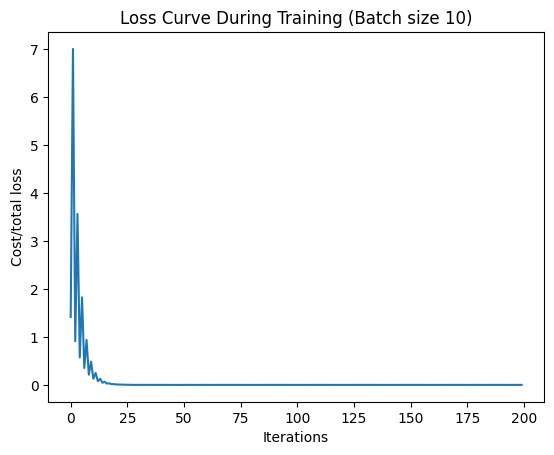

Validation loss for model (batch size 2): 0.0081
Validation loss for model1 (batch size 10): 0.0080


In [6]:
model1 = linear_regression(2, 1)  # Create a new linear regression model with 2 inputs and 1 output
optimizer1 = optim.SGD(model1.parameters(), lr=0.1)  # Create SGD optimizer for model1 with learning rate 0.1
train_loader1 = DataLoader(dataset=data_set, batch_size=10)  # Create DataLoader with batch size 10
LOSS1 = []  # List to store loss values for each iteration
epochs = 100  # Number of training epochs
for epoch in range(epochs):  # Loop over epochs
    for x, y in train_loader1:  # Loop over mini-batches from DataLoader
        yhat = model1(x)  # Compute predictions for the batch
        loss = criterion(yhat, y)  # Calculate mean squared error loss for the batch
        LOSS1.append(loss.item())  # Store the loss value in LOSS1
        optimizer1.zero_grad()  # Zero gradients before backward pass
        loss.backward()  # Compute gradients via backpropagation
        optimizer1.step()  # Update model parameters using optimizer
plt.plot(LOSS1)  # Plot the loss curve for model1
plt.xlabel("Iterations")  # Label x-axis
plt.ylabel("Cost/total loss")  # Label y-axis
plt.title("Loss Curve During Training (Batch size 10)")  # Set plot title
plt.show()  # Display the plot

torch.manual_seed(2)  # Set random seed for reproducibility
validation_data = Data2D()  # Create new validation dataset
Y = validation_data.y  # Get validation targets
X = validation_data.x  # Get validation inputs
with torch.no_grad():  # Disable gradient calculation for evaluation
    val_pred0 = model(X)  # Get predictions from original model
    val_loss0 = criterion(val_pred0, Y).item()  # Calculate validation loss for original model
    val_pred1 = model1(X)  # Get predictions from model1
    val_loss1 = criterion(val_pred1, Y).item()  # Calculate validation loss for model1
print(f"Validation loss for model (batch size 2): {val_loss0:.4f}")  # Print validation loss for original model
print(f"Validation loss for model1 (batch size 10): {val_loss1:.4f}")  # Print validation loss for model1

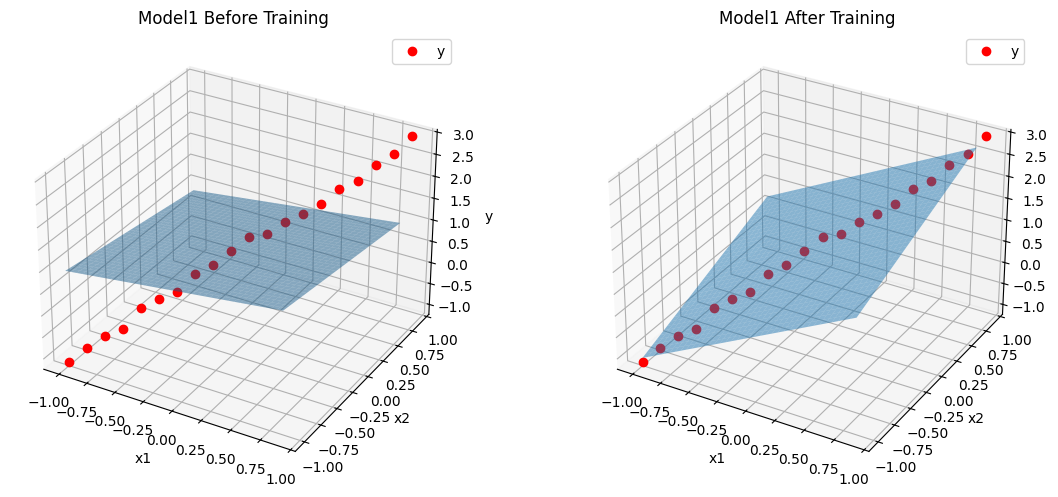

In [ ]:
# Save initial weights and bias before training
model1 = linear_regression(2, 1)  # Create a new linear regression model with 2 inputs and 1 output
optimizer1 = optim.SGD(model1.parameters(), lr=0.1)  # Create SGD optimizer for model1 with learning rate 0.1
train_loader1 = DataLoader(dataset=data_set, batch_size=10)  # Create DataLoader with batch size 10

initial_w1 = model1.state_dict()['linear.weight'].numpy()[0][0]  # Store initial weight for x1
initial_w2 = model1.state_dict()['linear.weight'].numpy()[0][1]  # Store initial weight for x2
initial_b = model1.state_dict()['linear.bias'].numpy()           # Store initial bias

LOSS1 = []  # List to store loss values for each iteration
epochs = 100  # Number of training epochs
for epoch in range(epochs):  # Loop over epochs
    for x, y in train_loader1:  # Loop over mini-batches from DataLoader
        yhat = model1(x)  # Compute predictions for the batch
        loss = criterion(yhat, y)  # Calculate mean squared error loss for the batch
        LOSS1.append(loss.item())  # Store the loss value in LOSS1
        optimizer1.zero_grad()  # Zero gradients before backward pass
        loss.backward()  # Compute gradients via backpropagation
        optimizer1.step()  # Update model parameters using optimizer

# Prepare data for plotting
x1 = data_set.x[:, 0].view(-1, 1).numpy()  # Get first feature as numpy array
x2 = data_set.x[:, 1].view(-1, 1).numpy()  # Get second feature as numpy array
y = data_set.y.numpy()                     # Get target values as numpy array
X, Y_ = np.meshgrid(                       # Create meshgrid for plotting the plane
    np.arange(x1.min(), x1.max(), 0.05),   # Range for x1
    np.arange(x2.min(), x2.max(), 0.05)    # Range for x2
)

# Plane before training
yhat_before = initial_w1 * X + initial_w2 * Y_ + initial_b  # Predicted values before training

# Plane after training
w1 = model1.state_dict()['linear.weight'].numpy()[0][0]     # Trained weight for x1
w2 = model1.state_dict()['linear.weight'].numpy()[0][1]     # Trained weight for x2
b = model1.state_dict()['linear.bias'].numpy()              # Trained bias
yhat_after = w1 * X + w2 * Y_ + b                          # Predicted values after training

fig = plt.figure(figsize=(12, 5))  # Create a figure with two subplots

ax1 = fig.add_subplot(1, 2, 1, projection='3d')  # First subplot for before training
ax1.plot(x1[:, 0], x2[:, 0], y[:, 0], 'ro', label='y')  # Plot data points
ax1.plot_surface(X, Y_, yhat_before, alpha=0.5)         # Plot regression plane before training
ax1.set_title('Model1 Before Training')                 # Set title
ax1.set_xlabel('x1')                                   # Label x-axis
ax1.set_ylabel('x2')                                   # Label y-axis
ax1.set_zlabel('y')                                    # Label z-axis
ax1.legend()                                           # Show legend

ax2 = fig.add_subplot(1, 2, 2, projection='3d')        # Second subplot for after training
ax2.plot(x1[:, 0], x2[:, 0], y[:, 0], 'ro', label='y') # Plot data points
ax2.plot_surface(X, Y_, yhat_after, alpha=0.5)         # Plot regression plane after training
ax2.set_title('Model1 After Training')                 # Set title
ax2.set_xlabel('x1')                                   # Label x-axis
ax2.set_ylabel('x2')                                   # Label y-axis
ax2.set_zlabel('y')                                    # Label z-axis
ax2.legend()                                           # Show legend

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()         # Display the plots